In [1]:
# import dependecies
%matplotlib inline 

#Start Python Imports
import math, time, random, datetime

#Data Manipulation
import numpy as np 
import pandas as pd 

#Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

#Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

#Machine Learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

#Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings("ignore")

#Loading Dataset
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Loading in the data 
 
 After we've downloaded the data, we need to get into the notebook.
 I've not stored my computer so I am using Kaggle right now.
 

In [2]:
#Import train & test data 
path = "/kaggle/input/titanic"
train = pd.read_csv(path + "/train.csv")
test = pd.read_csv(path + "/test.csv")
gender_submission = pd.read_csv(path + "/gender_submission.csv") #example of what a submission should look like

In [3]:
#View first 5 sample in train.
train.sample(5)

PassengerId  Survived  Pclass  \
453          454         1       1   
849          850         1       1   
801          802         1       2   
188          189         0       3   
681          682         1       1   

                                             Name     Sex   Age  SibSp  Parch  \
453                      Goldenberg, Mr. Samuel L    male  49.0      1      0   
849  Goldenberg, Mrs. Samuel L (Edwiga Grabowska)  female   NaN      1      0   
801   Collyer, Mrs. Harvey (Charlotte Annie Tate)  female  31.0      1      1   
188                              Bourke, Mr. John    male  40.0      1      1   
681                            Hassab, Mr. Hammad    male  27.0      0      0   

         Ticket     Fare Cabin Embarked  
453       17453  89.1042   C92        C  
849       17453  89.1042   C92        C  
801  C.A. 31921  26.2500   NaN        S  
188      364849  15.5000   NaN        Q  
681    PC 17572  76.7292   D49        C

In [4]:
#View first 5 sample in train.
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [5]:
#Looking gender_submission dataframe
gender_submission.sample(5)

PassengerId  Survived
315         1207         1
180         1072         0
75           967         0
362         1254         1
154         1046         0

In [6]:
#Looking how long this dataframes.
print(len(train))
print(len(test))
print(len(gender_submission))

891
418
418


## Data Description

**Survival:** 0 = No, 1 = Yes

**pclass(Ticket class):** 1=1st, 2=2nd, 3=3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C=Cherbourg, Q=Queenstown, S=Southampton


In [7]:
train.describe().T

count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292

### What missing values are there ? 
Where are the holes in our data?

These are rows which are missing value or have NaN instead of something like the rest of column

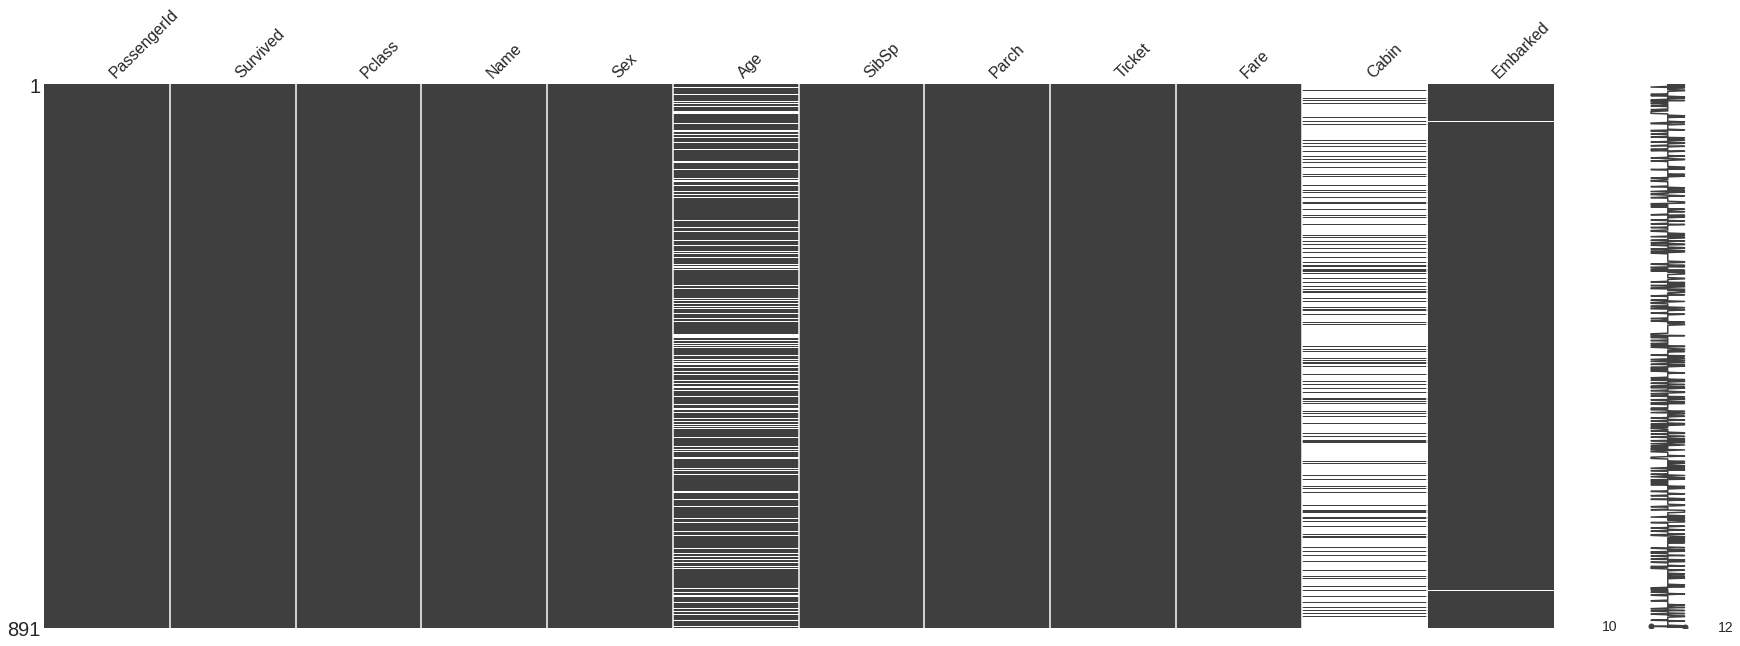

In [8]:
#Plot graphic of missing values
missingno.matrix(train, figsize = (30, 10)) #widht, lenght 

Ok we can clearly see some missing values here. Especially in the cabin column.

It's important to visualize missing values early so you know where the major holes are in your dataset.

Knowing this information will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.

In [9]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
#Let's write a little fuctions to show us how many missing values there are

def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print('Number of missing or NaN values for each columns:')
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length - total_column_values
        #missing_vals.append(str(column) + "column has {} missing or NaN values.".format())
    return missing_vals

missing_values = find_missing_values(train, columns = train.columns)
missing_values

Number of missing or NaN values for each columns:


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [11]:
#We can do with very basic code:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### To perform our data analysis, let's create two new dataframes

We'll create one for exploring discretised  continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables

In [12]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables 

In [13]:
0 - 100 # all numbers between 0 and 100
0 - 10  # all numbers between 0 and 10 have a label 1
10 - 20 # 2
20 - 30 # 3....

-10

### What datatypes are in the dataframe?

As a general rule of thumb, features with a datatype of object could be considered categorical features. And those which are floats or ints(numbers) could be considered numerical features.

However, as we dig deeper, we might find features which are numerical may actually be categorical.

The goal for the next few steps is to figure out how best to process the data so our machine learning model can learn from it.

Ideally, all the features will be encoded into a numerical value of some kind.

In [14]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Let's explore each of these features invidually

We'll go through each column iteratively and see which ones to use in our first models. Some may need more preprocessing than others to get ready.



### Target Feature: Survived

Description: Whether the passenger survived or not.

Key:0 = did not survive, 1 = survived

This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


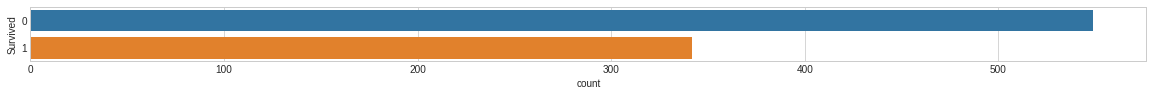

In [15]:
# How many people survived?
fig = plt.figure(figsize = (20, 1))
sns.countplot(y = "Survived", data = train);
print(train.Survived.value_counts())

In [16]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train["Survived"]
df_con['Survived'] = train["Survived"]

In [17]:
df_bin.head()

Survived
0         0
1         1
2         1
3         1
4         0

In [18]:
df_con.head()

Survived
0         0
1         1
2         1
3         1
4         0

### Feature: Pclass

Description: The ticket class of the passenger.

Key: 1=1st, 2=2nd, 3=3rd

#### Let's plot the distribution

We will look at the distribution of each feature first if we can do understand what kind of spread there is across the dataset.

For example, if there are values which are completely outside of the distribution, we may now want to include them in our model.

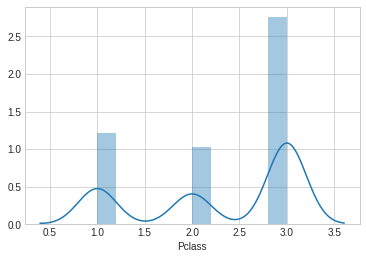

In [19]:
sns.distplot(train.Pclass)

 We cann see with this feature, the values are numerical(1, 2 and 3) but they are categories.
 
 How do we know this? Because a passenger in Class 3 doesn't 

In [20]:
# How many missing variables does Pclass have ?
train.Pclass.isnull().sum()

0

Since there are no missing values in Pclass, let's add it to our sub dataframes.


In [21]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [22]:
df_con.head()

Survived  Pclass
0         0       3
1         1       1
2         1       3
3         1       1
4         0       3

## Feature: Name 

Description: The name of the passenger.

In [23]:
# How many different names are there ? 
train.Name.value_counts()[:20]

Skoog, Master. Karl Thorsten                      1
Thayer, Mr. John Borland Jr                       1
Boulos, Mr. Hanna                                 1
Cleaver, Miss. Alice                              1
Silvey, Mrs. William Baird (Alice Munger)         1
Moussa, Mrs. (Mantoura Boulos)                    1
Skoog, Miss. Margit Elizabeth                     1
Hanna, Mr. Mansour                                1
Bowen, Mr. David John "Dai"                       1
Thayer, Mr. John Borland                          1
Samaan, Mr. Youssef                               1
Ford, Mr. William Neal                            1
Morley, Mr. Henry Samuel ("Mr Henry Marshall")    1
Beane, Mr. Edward                                 1
Sdycoff, Mr. Todor                                1
Collyer, Mr. Harvey                               1
Meyer, Mr. Edgar Joseph                           1
Chambers, Mr. Norman Campbell                     1
Leader, Dr. Alice (Farnham)                       1
Thomas, Mast

Every row has a unique name. This is equivalent to the passenger ID. But name could be used differently.

Can you think of ways you could reduce the number of different name? Or create new features out of the names?

**Note:** Because of so many different names and to keep this EDA fast, we won't move forward using the name variable. 

## Feature: Sex

Description: The sex of the passenger (male or female)

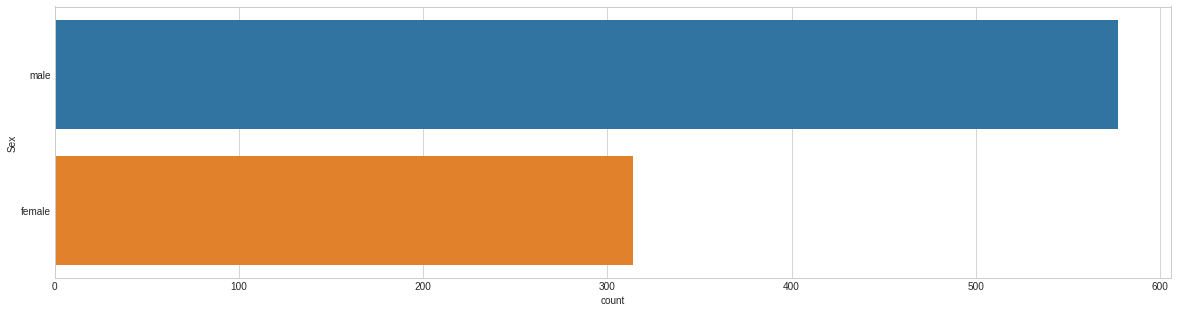

In [24]:
# Let's view the distribution of Sex
plt.figure(figsize = (20, 5))
sns.countplot(y = "Sex", data = train)

In [25]:
# Are there any missing value in Sex ?
train.Sex.isnull().sum()

0

Since this is already binary variable (male or female), let's add it straight to our subset dataframes.

In [26]:
 train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [27]:
# add Sex to the subset dataframes
df_bin["Sex"] = train["Sex"]
#df_bin.loc[df_bin]
df_bin["Sex"] = np.where(df_bin['Sex'] == 'female', 1, 0)

df_con["Sex"] = train["Sex"]

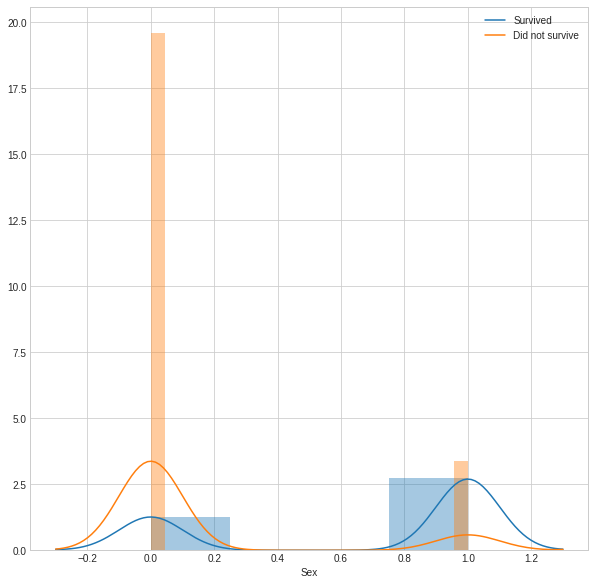

In [28]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived', "bw": "0.1"}); #bandwidth
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive',"bw": "0.1"});

Not many people survived. But of those who did, more were female.

## Feature: Age

Description: The age of the passenger.

In [29]:
# How many missing values does age have?
missing_values['Age']

177

Out of a total 891 rows, that's almost one quarter of the dataset.

What would you do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or would you get rid of them completely?

We won't answer these questions in our initial EDA but this is something we would definitely revisit at a later date.

In [30]:
#Once the Age values have been fixed up, we can add them to our sub dataframes.
#df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
#df_con['Age'] = train['Age'] # non-bucketed

In [31]:
df_bin.sample(5)

Survived  Pclass  Sex
209         1       1    0
569         1       3    0
239         0       2    0
649         1       3    1
35          0       1    0

**Challenge:** How would you fill the missing variables in the Age column?

**Function to create count and distribution visualisations.**

In [32]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived", 'bw': '0.1'});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive", 'bw': '0.1'});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived", 'bw': '0.1'});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive", 'bw': '0.1'});

## Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [33]:
# How many missing values does SibSp have?
missing_values["SibSp"]

0

In [34]:
# What values are there ?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Let's add SibSp to our subset dataframes and view the distribution.

In [35]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

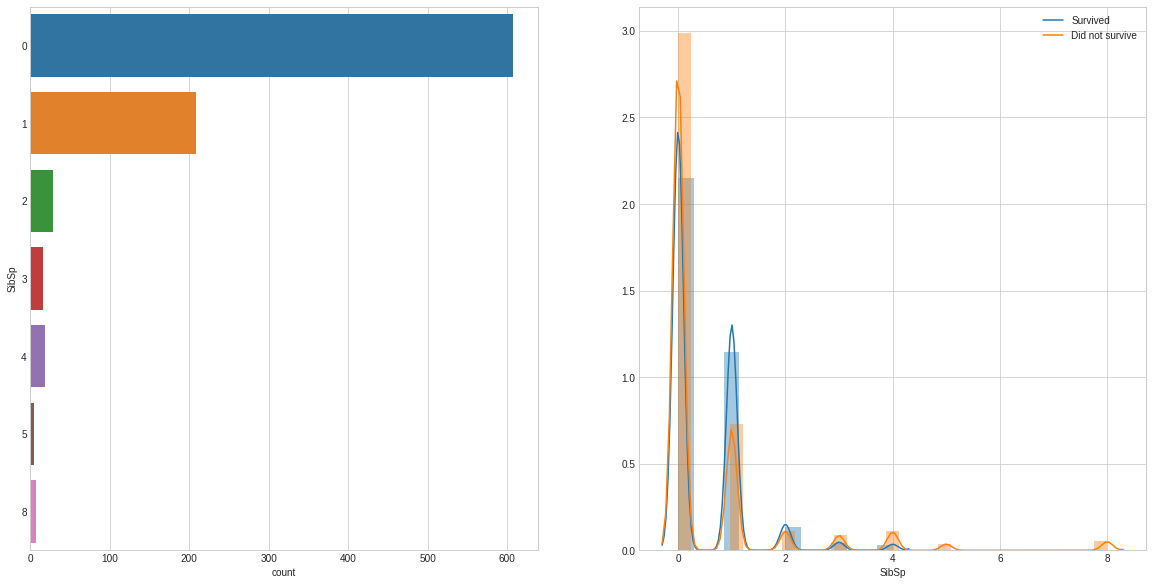

In [36]:
# Visualize the counts of SibSp and the distributşon of the values
# against Survived
plot_count_dist(train,
               bin_df = df_bin,
               label_column = 'Survived',
               target_column = 'SibSp',
               figsize = (20, 10))

What does the graph on the right tell us?

## Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.


In [37]:
# How many missing values does Parch have?
missing_values["Parch"]

0

In [38]:
#What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [39]:
# Add parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

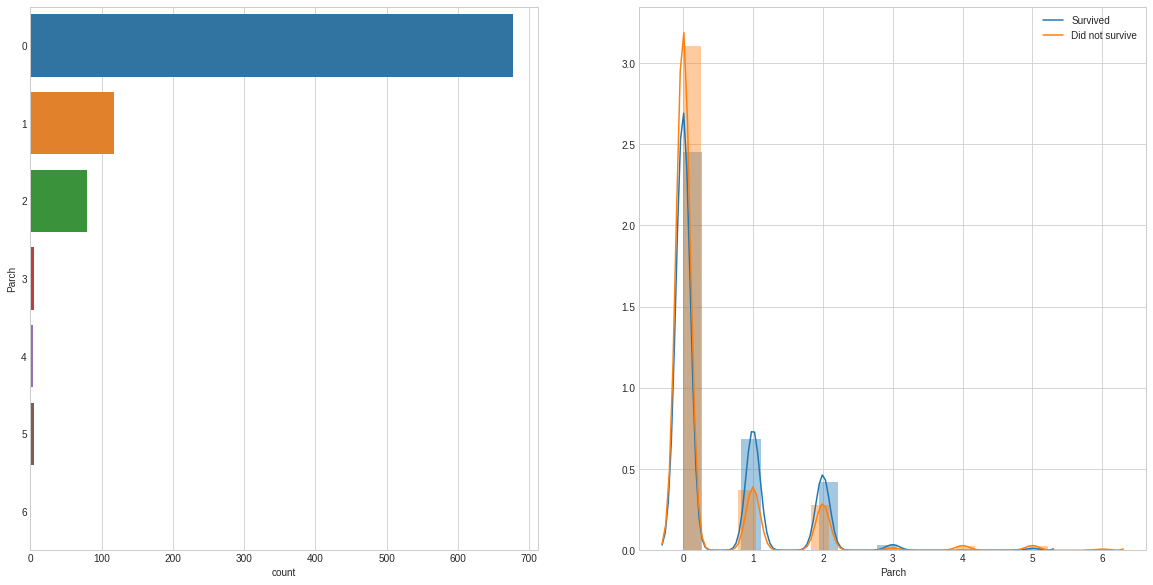

In [40]:
# Visualize the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train,
               bin_df = df_bin,
               label_column = 'Survived',
               target_column = 'Parch',
               figsize = (20, 10))

What does the graph on the right tell us about ```Parch``` ? 

In [41]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [42]:
df_con.head()

Survived  Pclass     Sex  SibSp  Parch
0         0       3    male      1      0
1         1       1  female      1      0
2         1       3  female      0      0
3         1       1  female      1      0
4         0       3    male      0      0

## Feature: Ticket

Description: The ticket number of the boarding passenger.

In [43]:
# How many missing values does Ticket have?
missing_values["Ticket"]

0

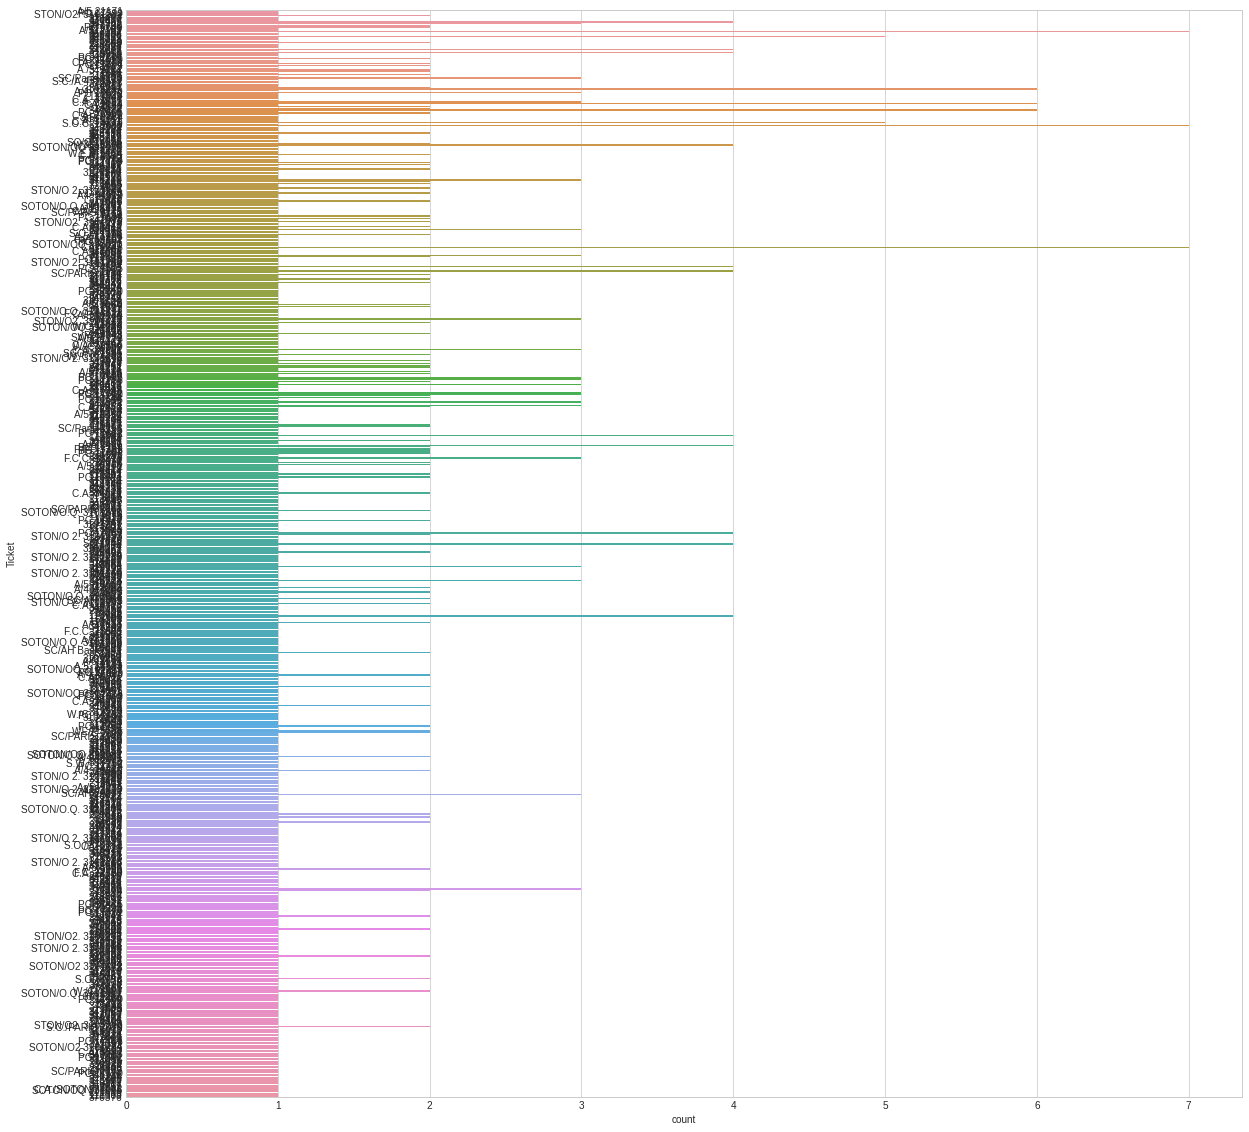

In [44]:
# How many kinds of ticket are there?
plt.figure(figsize = (20, 20))
sns.countplot(y = "Ticket", data = train);

That doesn't look too good, what about another way of looking at it?

In [45]:
# How many kinds of ticket are there ? 
train.Ticket.value_counts()[:20]

347082           7
1601             7
CA. 2343         7
3101295          6
CA 2144          6
347088           6
S.O.C. 14879     5
382652           5
17421            4
2666             4
113781           4
349909           4
347077           4
PC 17757         4
19950            4
113760           4
LINE             4
W./C. 6608       4
4133             4
SC/Paris 2123    3
Name: Ticket, dtype: int64

In [46]:
# How many unique kinds of Ticket are there ?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


681 unique values is too many for now. So we won't use Ticket in our subset dataframes.

There may be some way to reduce this down.

**Challenge:** How could you reduce the Ticket feature? Is it even possible?

Hint: It may be similar to what you could do with Name.

## Feature: Fare

Description: How much the ticket cost.

In [47]:
# How many missing values does Fare have ?
missing_values['Fare']

0

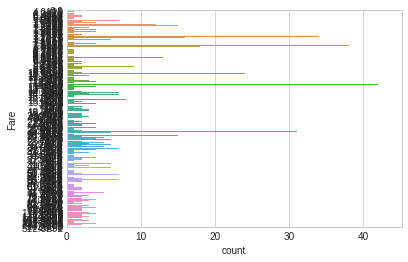

In [48]:
# How many different values of Fare are there ?
sns.countplot(y = 'Fare', data = train);

In [49]:
# What kind of variable is Fare ? 
train.Fare.dtype

dtype('float64')

In [50]:
# How many unique kinds of Fare are there ?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.



In [51]:
# Add Fare to sub dataframes.
df_con['Fare'] = train['Fare']   # Continuous
df_bin['Fare'] = pd.cut(train['Fare'], 5) # Discretised


In [52]:
df_bin.head()

Survived  Pclass  Sex  SibSp  Parch               Fare
0         0       3    0      1      0  (-0.512, 102.466]
1         1       1    1      1      0  (-0.512, 102.466]
2         1       3    1      0      0  (-0.512, 102.466]
3         1       1    1      1      0  (-0.512, 102.466]
4         0       3    0      0      0  (-0.512, 102.466]

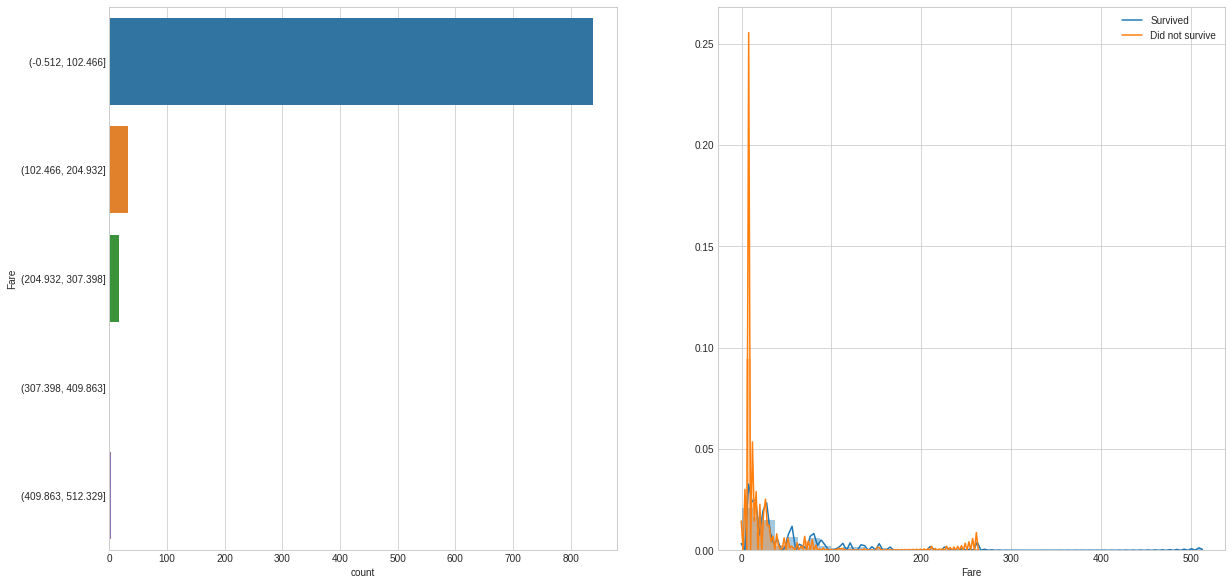

In [53]:
# Visualize the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data = train,
               bin_df = df_bin,
               label_column = 'Survived',
               target_column = 'Fare',
               figsize = (20, 10),
               use_bin_df = True)

**Challenge:** How would you change the Fare bins ?

## Feature: Cabins

Description: The cabin number where the passenger was staying.

In [54]:
# How many missing values does Cabin have ?
missing_values['Cabin']

687

In [55]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [56]:
# What do the Cabin values look like ?
train.Cabin.value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
D              3
C22 C26        3
              ..
E58            1
F E69          1
C95            1
E77            1
A31            1
Name: Cabin, Length: 147, dtype: int64

Since there are too many missing values. we won't use Cabin for our initial models and won't add it to our sub dataframes.

But how could you modify Cabin to be more usable?

What could you do about missing values ?

## Feature: Embarked

Description: The port where the passenger boarded the Titanic.

Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [57]:
# How many missing values does Embarked have ?
missing_values['Embarked']

2

In [58]:
# What kind of values are there in Embarked ?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

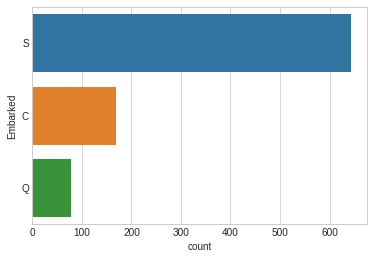

In [59]:
sns.countplot(y = 'Embarked', data = train)

**How can we deal with the 2 missing values of Embarked ?**

Another option would be to randomly assign a value C,Q, S to each row.

What are the pros and cons of each?

For now, we will remove those rows.

In [60]:
# Add Embarked to sub dataframes.
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [61]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset = ['Embarked'])
df_bin = df_bin.dropna(subset = ['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.


## Feature Encoding

Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (df_bin) with one-hot encoding and our continuous dataframe (df_con) with the label encoding function from sklearn.

In [62]:
df_bin.head()

Survived  Pclass  Sex  SibSp  Parch               Fare Embarked
0         0       3    0      1      0  (-0.512, 102.466]        S
1         1       1    1      1      0  (-0.512, 102.466]        C
2         1       3    1      0      0  (-0.512, 102.466]        S
3         1       1    1      1      0  (-0.512, 102.466]        S
4         0       3    0      0      0  (-0.512, 102.466]        S

In [63]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns = one_hot_cols)

df_bin_enc.head()

Survived  Pclass_1  Pclass_2  Pclass_3  Sex_0  Sex_1  SibSp_0  SibSp_1  \
0         0         0         0         1      1      0        0        1   
1         1         1         0         0      0      1        0        1   
2         1         0         0         1      0      1        1        0   
3         1         1         0         0      0      1        0        1   
4         0         0         0         1      1      0        1        0   

   SibSp_2  SibSp_3  ...  Parch_5  Parch_6  Fare_(-0.512, 102.466]  \
0        0        0  ...        0        0                       1   
1        0        0  ...        0        0                       1   
2        0        0  ...        0        0                       1   
3        0        0  ...        0        0                       1   
4        0        0  ...        0        0                       1   

   Fare_(102.466, 204.932]  Fare_(204.932, 307.398]  Fare_(307.398, 409.863]  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   

   Fare_(409.863, 512.329]  Embarked_C  Embarked_Q  Embarked_S  
0                        0           0           0           1  
1                        0           1           0           0  
2                        0           0           0           1  
3                        0           0           0           1  
4                        0           0           0           1  

[5 rows x 28 columns]

In [64]:
df_con.head()

Survived  Pclass     Sex  SibSp  Parch     Fare Embarked
0         0       3    male      1      0   7.2500        S
1         1       1  female      1      0  71.2833        C
2         1       3  female      0      0   7.9250        S
3         1       1  female      1      0  53.1000        S
4         0       3    male      0      0   8.0500        S

In [65]:
# Label Encode all continuous values using LabelEncoder()
df_con_enc = df_con.apply(LabelEncoder().fit_transform)

df_con_enc.head()

Survived  Pclass  Sex  SibSp  Parch  Fare  Embarked
0         0       2    1      1      0    18         2
1         1       0    0      1      0   207         0
2         1       2    0      0      0    41         2
3         1       0    0      1      0   189         2
4         0       2    1      0      0    43         2

## Start Building Machine Learning Models

Now our  data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's separate the data

In [66]:
# Select the dataframe we want to use first for predictions
selected_df = df_con_enc

In [67]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis = 1) # data
y_train = selected_df.Survived # labels

In [68]:
X_train

Pclass  Sex  SibSp  Parch  Fare  Embarked
0         2    1      1      0    18         2
1         0    0      1      0   207         0
2         2    0      0      0    41         2
3         0    0      1      0   189         2
4         2    1      0      0    43         2
..      ...  ...    ...    ...   ...       ...
886       1    1      0      0    85         2
887       0    0      0      0   153         2
888       2    0      1      2   131         2
889       0    1      0      0   153         0
890       2    1      0      0    30         1

[889 rows x 6 columns]

In [69]:
# Shape of the data (without labels)
X_train.shape

(889, 6)

In [70]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64

In [71]:
# Shape of the labels
y_train.shape

(889,)

### Define a function to fit Machine Learning Algorithms

Since many of the algorithms we will use are from the sklearn library, they all take similar(practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [72]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv = cv,
                                                  n_jobs = -1)
    # Cross-Validatiob accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [73]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),
                                                      X_train,
                                                      y_train,
                                                      10)
log_time = (time.time() - start_time)
print("Accuracy: %s " % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.42 
Accuracy CV 10-Fold: 78.18
Running Time: 0:00:02.555225


### K-Nearest Neighbours

In [74]:
# K-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 81.44
Accuracy CV 10-Fold: 73.68
Running Time: 0:00:00.160306


### Gaussian NB

In [75]:
# Gaussian NB# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 76.72
Accuracy CV 10-Fold: 76.38
Running Time: 0:00:00.060172


### Linear Support Vector Machines (SVC)

In [76]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 70.42
Accuracy CV 10-Fold: 69.97
Running Time: 0:00:00.224047


### Stochastic Gradient Descent

In [77]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))


Accuracy: 61.75
Accuracy CV 10-Fold: 64.9
Running Time: 0:00:00.082860


### Decision Tree

In [78]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))


Accuracy: 92.46
Accuracy CV 10-Fold: 79.87
Running Time: 0:00:00.078751


### Gradient Boost Trees

In [79]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.39
Accuracy CV 10-Fold: 81.1
Running Time: 0:00:00.700078


### Catboost Algorithm

CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

In [80]:
# View the data for Catboost model
X_train.head()

Pclass  Sex  SibSp  Parch  Fare  Embarked
0       2    1      1      0    18         2
1       0    0      1      0   207         0
2       2    0      0      0    41         2
3       0    0      1      0   189         2
4       2    1      0      0    43         2

In [81]:
# View the labels for the Catboost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [82]:
# Define the categorical features for the Catboost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 3, 4, 5])

This means Catboost has picked up that all variables except ```Fare``` can be treated as categorical.

In [83]:
# Use the Catboost Pool() function to pool together the trainin data and categorical feature labels
train_pool = Pool(X_train,
                 y_train,
                 cat_features)

In [84]:
# Catboost model definition
catboost_model = CatBoostClassifier(iterations = 1000,
                                   custom_loss = ['Accuracy'],
                                   loss_function = 'Logloss')
# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot = True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)


Learning rate set to 0.009797


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6873671	total: 60.4ms	remaining: 1m
1:	learn: 0.6820241	total: 65.9ms	remaining: 32.9s
2:	learn: 0.6762783	total: 69.3ms	remaining: 23s
3:	learn: 0.6714483	total: 73.4ms	remaining: 18.3s
4:	learn: 0.6662935	total: 78.2ms	remaining: 15.6s
5:	learn: 0.6605739	total: 82.8ms	remaining: 13.7s
6:	learn: 0.6554674	total: 86.9ms	remaining: 12.3s
7:	learn: 0.6506963	total: 89.8ms	remaining: 11.1s
8:	learn: 0.6458177	total: 93.8ms	remaining: 10.3s
9:	learn: 0.6414410	total: 96.6ms	remaining: 9.56s
10:	learn: 0.6368860	total: 100ms	remaining: 9s
11:	learn: 0.6322663	total: 104ms	remaining: 8.56s
12:	learn: 0.6280648	total: 108ms	remaining: 8.17s
13:	learn: 0.6235529	total: 111ms	remaining: 7.83s
14:	learn: 0.6188170	total: 115ms	remaining: 7.52s
15:	learn: 0.6144028	total: 118ms	remaining: 7.24s
16:	learn: 0.6104758	total: 121ms	remaining: 7s
17:	learn: 0.6068397	total: 125ms	remaining: 6.81s
18:	learn: 0.6029228	total: 128ms	remaining: 6.63s
19:	learn: 0.5992066	total: 133ms	remainin

In [85]:
# Perform Catboost cross-validation
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as other models)
cv_data = cv(train_pool,
            cv_params,
            fold_count = 10,
            plot = True)

# How long did it take ?
catboost_time = (time.time() - start_time)

# Catboost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6765653	test: 0.6765147	best: 0.6765147 (0)	total: 422ms	remaining: 7m 1s
1:	learn: 0.6597969	test: 0.6605866	best: 0.6605866 (1)	total: 812ms	remaining: 6m 45s
2:	learn: 0.6457114	test: 0.6466992	best: 0.6466992 (2)	total: 1.17s	remaining: 6m 29s
3:	learn: 0.6317074	test: 0.6325672	best: 0.6325672 (3)	total: 1.53s	remaining: 6m 20s
4:	learn: 0.6188325	test: 0.6200562	best: 0.6200562 (4)	total: 1.91s	remaining: 6m 19s
5:	learn: 0.6073101	test: 0.6085066	best: 0.6085066 (5)	total: 2.28s	remaining: 6m 18s
6:	learn: 0.5958211	test: 0.5974038	best: 0.5974038 (6)	total: 2.68s	remaining: 6m 20s
7:	learn: 0.5851364	test: 0.5873458	best: 0.5873458 (7)	total: 3.06s	remaining: 6m 19s
8:	learn: 0.5753407	test: 0.5778211	best: 0.5778211 (8)	total: 3.45s	remaining: 6m 20s
9:	learn: 0.5663144	test: 0.5695180	best: 0.5695180 (9)	total: 3.86s	remaining: 6m 22s
10:	learn: 0.5577853	test: 0.5616115	best: 0.5616115 (10)	total: 4.23s	remaining: 6m 20s
11:	learn: 0.5494584	test: 0.5537349	best:

In [86]:
# Print put the Catboost model metrics 
print("---CatBoost Metrics---")
print(f"Accuracy: {acc_catboost}")
print(f"Accuracy Cross-Validation 10 Folds: {acc_cv_catboost}")
print(f"Running Time: {datetime.timedelta(seconds = catboost_time)}")

---CatBoost Metrics---
Accuracy: 88.08
Accuracy Cross-Validation 10 Folds: 81.32
Running Time: 0:06:58.288718


## Model Results

Which model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from .fit() can randomly score higher than usual.



### Regular Accuracy Scores

In [87]:
models = pd.DataFrame({
    'Model': ['KNN','Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Descent','Linear Support Vector Machine', 
              'Decision Tree', 'Gradient Boosting Trees', 'Catboost'],
    'Score': [
        acc_knn,
        acc_log,
        acc_gaussian,
        acc_sgd,
        acc_linear_svc,
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Regular Accuracy Scores---")
models.sort_values(by = 'Score', ascending = False)

---Regular Accuracy Scores---


Model  Score
5                  Decision Tree  92.46
7                       Catboost  88.08
6        Gradient Boosting Trees  86.39
0                            KNN  81.44
1            Logistic Regression  79.42
2                    Naive Bayes  76.72
4  Linear Support Vector Machine  70.42
3    Stochastic Gradient Descent  61.75

In [88]:
cv_models = pd.DataFrame({
    'Model': ['KNN','Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Descent','Linear Support Vector Machine', 
              'Decision Tree', 'Gradient Boosting Trees', 'Catboost'],
    'Score': [
        acc_cv_knn,
        acc_cv_log,
        acc_cv_gaussian,
        acc_cv_sgd,
        acc_cv_linear_svc,
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print("---Cross-Validation Accuracy Scores---")
cv_models.sort_values(by = 'Score', ascending = False)

---Cross-Validation Accuracy Scores---


Model  Score
7                       Catboost  81.32
6        Gradient Boosting Trees  81.10
5                  Decision Tree  79.87
1            Logistic Regression  78.18
2                    Naive Bayes  76.38
0                            KNN  73.68
4  Linear Support Vector Machine  69.97
3    Stochastic Gradient Descent  64.90

We can see from the tables, the CatBoost model had the best results. Getting just under 82% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the .fit() models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

**Challenge:** How could you improve the CatBoost model?

 ### Feature Importance
 
 Which features of the best model were most important for making predictions?

In [89]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns}) 
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png')

imp       col
2  10.766248     SibSp
5  12.975727  Embarked
3  13.595283     Parch
4  16.272008      Fare
0  21.919278    Pclass
1  24.471455       Sex

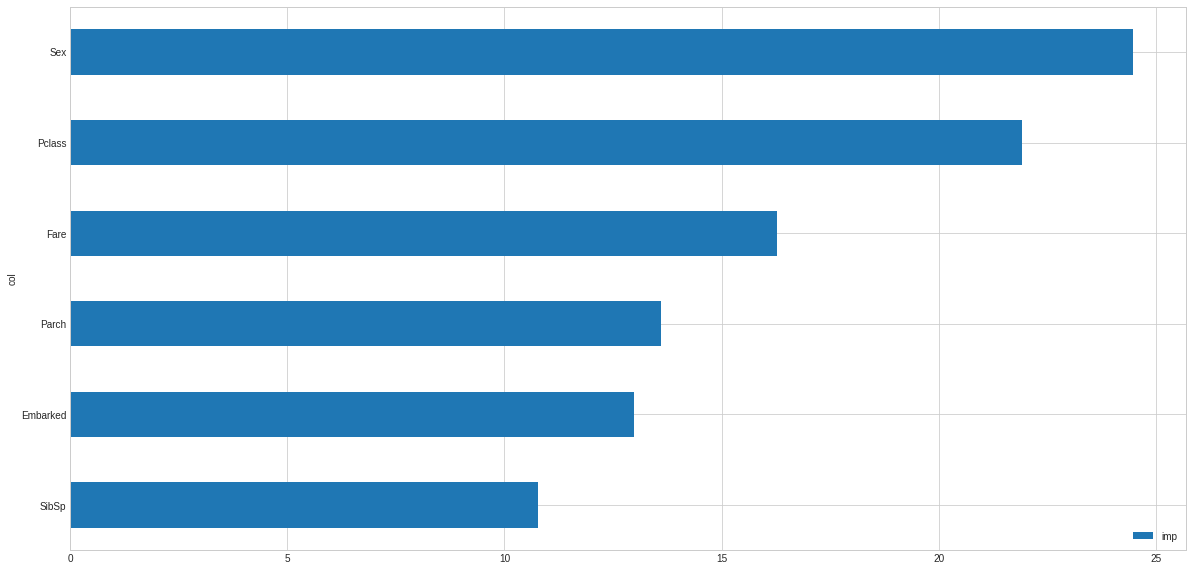

In [90]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)


**Why would you want feature importance?**

Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

### Precision and Recall

Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

**Recall** = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

**Precision** = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an **F1 score**.

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

<img src="https://lawtomated.com/wp-content/uploads/2019/10/Precision_1-300x84.png" alt="drawing" width="388" height = "108"/>


<img src="https://lawtomated.com/wp-content/uploads/2019/10/Recall_1-585x133.png" alt="drawing" width="388" height = "108"/>


<img src="https://lawtomated.com/wp-content/uploads/2019/10/F1-Score-300x76.png" alt = "drawing" width="388" height= "108"/>


In [91]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8895629218329411
Recall: 0.7111264705882352
F1: 0.7898709737285132
AUC: 0.9093503562627238


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

**Challenge:** What are some ways to visualise precision and recall? Hint: You may want to look into what a confusion matrix is, you can find much more information in this blog post: [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

### Submission 

Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the test dateframe, encode them and make a prediciton with our model.

In [92]:
# We need our test dataframe to look like this one
X_train.head()

Pclass  Sex  SibSp  Parch  Fare  Embarked
0       2    1      1      0    18         2
1       0    0      1      0   207         0
2       2    0      0      0    41         2
3       0    0      1      0   189         2
4       2    1      0      0    43         2

In [93]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [94]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [95]:
# Let's look at test, it should have one hot encoded columns now
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

The columns in test have been converted to the same format at df_con_enc. Now we can make predictions on the test dataframe columns we built a model on.

We can find the columns we made predictions on with ```X_train.columns```.

In [96]:
# Create a list of columns to be used for the predictions
wanted_test_columns = df_con.drop('Survived', axis = 1).columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [97]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns]
                                    .apply(LabelEncoder().fit_transform))

In [98]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [99]:
# Create a submission dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

We need our ```submission``` dataframe to look like the ```gender_submission``` dataframe, so we'll turn the ```Survived``` column into integers.

In [100]:
# Let's convert our submission dataframe 'Survived' column to into
submission['Survived'] = submission['Survived'].astype(int)
print("Converted Survived column to integers.")

Converted Survived column to integers.


In [101]:
# Are our test and submission dataframes the same length ? 
if len(submission) == len(test):
    print(f"Submission dataframe is the same length as test {len(submission)} rows")
else:
    print(f"Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test 418 rows


In [102]:
# Convert submission dataframe to csv for submission to csv
# for Kaggle submission
submission.to_csv('../catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [103]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

###  Now submit your .csv to Kaggle!

https://www.kaggle.com/c/titanic/submit

### Possible Extensions


These are all possible options to improve this pipeline. I'd suggest starting with the feature engineering (improving and manipulating the existing data) first.
<ol>
<ul>

-What can you do with the ```Age``` feature?
    <ul>-How would fill up all the missing values?</ul>
        <ul>-You may want to look into the ```interpolate()``` function of Pandas for this.</ul>
</ul>    

1.What can you do with the ```Name``` feature?
    <ul>-What titles did the passengers have? Did this influence their survival?</ul>
    
    
2.What can you do with the ```Cabin``` feature?
    <ul>-Is there a way to see whether they had a cabin or not?</ul>
    
3.Can you combine the ```SibSp``` and ```Parch``` features to see if the person was alone or not?
    
4.Could you do a ```PCA/feature analysis``` to see what features are more important than others?
    <ul>-Does removing the less important model features improve the model?</ul>

5.The models take a bunch of hyperparameters but we've mostly used the default settings, is there a way to find which hyperparameters are best to use?
    <ul>-Tip: Check out the CatBoost with Python tutorial and the [hyperopt library](https://github.com/hyperopt/hyperopt) to see if you can improve the ```CatBoost``` model</ul>
</ol>

### References and Learn More

<ul>
-Daniel Bourke livestream video<br>
    
-[Sklearn Classification Notebook by Daniel Furasso](https://github.com/dformoso/sklearn-classification/blob/master/Data%20Science%20Workbook%20-%20Census%20Income%20Dataset.ipynb) - Daniel has  done some epic work showing how you can take a bigger dataset, clean it up and perform some similar classification work from scratch. It would be a great next step after going through this one.
    
-[Encoding categorical features in Python blog post by Practical Python Business](http://pbpython.com/categorical-encoding.html)- this blog post sheds some great light on how to deal with categorical features in Python. The rest of the website contains plenty more great information for using Python in a business environment.
    
-[Shap library](https://github.com/slundberg/shap) - a great (and beautiful) alternative to viewing feature importance. Can you use this to improve on the feature importance graphics?
</ul>

### Contact me

#### Mert Bozkır
[LinkedIn](https://www.linkedin.com/in/mertbozkir/)

[Github](https://github.com/mertbozkir)